In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [13]:
!pip install -U classiq -q

In [14]:
import classiq
classiq.authenticate(overwrite=True)

Your user code: VRBB-VPQK
If a browser doesn't automatically open, please visit this URL from any trusted device: https://auth.classiq.io/activate?user_code=VRBB-VPQK


In [15]:
from classiq import *

In [16]:
# 2**4 = 16, for 16 nodes we need 4 qubits
size = 4

@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    prob[(i+1)% 16]=0.3     # some experiment instead of 50%-50%
    prob[(i-1)% 16]=0.7
    print(f'State={i}, prob vec ={prob}')

    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc
def W_operator(vertices:QNum, adjacent_vertices: QNum):
  # for a line, there are no_of_nodes - 1 edges
    for i in range(2**size - 1):
      W_iteration(i,vertices,adjacent_vertices)


@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices+adjacent_vertices)%2) ==1)


@qfunc
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))


@qfunc
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)


In [17]:
qmod = create_model(main)
qprog = synthesize(qmod)
job = execute(qprog)
results = job.result()[0].value.counts
print(results)

State=0, prob vec =[0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7]
State=1, prob vec =[0.7, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.7, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.7, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.7, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.7, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.7, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.7, 0, 0.3, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.7, 0, 0.3, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.7, 0, 0.3, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7, 0, 0.3, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7, 0, 0.3, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7, 0, 0.3, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7,

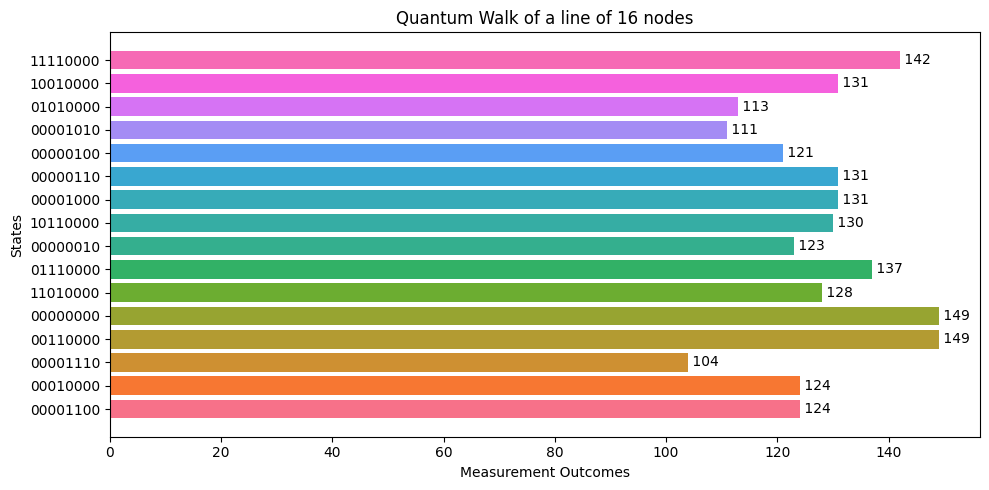

In [18]:
import seaborn as sns
import numpy as np

ind = np.arange(len(results))
palette = sns.color_palette("husl", len(results))


plt.figure(figsize=(10,5))

plt.barh(ind, list(results.values()), color = palette)
plt.yticks(ind, list(results.keys()))

for i, (key, value) in enumerate(results.items()):
    plt.text(value, i, f' {value}', va='center')

plt.xlabel('Measurement Outcomes')
plt.ylabel('States')
plt.title('Quantum Walk of a line of 16 nodes')
plt.tight_layout()
plt.show()

In [19]:
show(qprog)

Opening: https://platform.classiq.io/circuit/d4837b1a-781b-4acd-958d-9f35bb69054d?version=0.43.3
